# Usando Deep learning de series temporales para predecir el precio de la electricidad en España

Objetivo de la investigación:
Los objetivos principales de esta tesis son los siguientes:
1. Evaluar la literatura existente sobre previsión de precios de la electricidad y técnicas de aprendizaje profundo aplicadas a datos de series temporales.
2. Recopilar y preprocesar datos del mercado eléctrico, incluyendo precios históricos ,demanda, y condiciones meteorológicas en España.(datos originales de Kaggle https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/data?select=weather_features.csv ).
3. Aplicar diversos modelos de aprendizaje profundo, incluyendo redes neuronales recurrentes(RNNs), redes de memoria a largo plazo(LSTM), y unidades recurrentes cerradas(GRUs), a las series temporales de precios de la electricidad. (Or tal vez algo modelos combinados ej: LSTM-XGBoost ect..)
4. Evaluar y comparar el rendimiento de los modelos de aprendizaje profundo basándose en varias métricas, como el error medio absoluto (MAE), el error medio cuadrático (MSE), el error medio cuadrático radicular (RMSE) y el error medio porcentual absoluto (MAPE).
5. Investigar el impacto de diferentes variables de entrada e hiperparámetros en el rendimiento del modelo.
6. Interpretar los resultados y aportar ideas para futuras investigaciones y aplicaciones prácticas.

In [324]:
#Import de librerías
import pandas as pd


In [325]:
#Carga de archivos csv
weather_df = pd.read_csv("weather_features.csv") #https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/data?select=weather_features.csv
energy_df = pd.read_csv("energy_dataset.csv") # https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/data?select=energy_dataset.csv

En primer lugar, vamos a parsear las columnas de fecha para poder trabajar con ellas en el futuro.

In [326]:
weather_df.head()

                      dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_i

In [327]:
energy_df.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

En ambas tablas existe una columna que indica la hora a la que se toma la medida:
- 'dt_iso' en el dataframe weather_df
- 'time' en el dataframe enery_df

Modificamos el nombre de la columna 'dt_iso' para tener el mismo nombre en ambos dataframes

In [328]:
weather_df['time'] = pd.to_datetime(weather_df['dt_iso'],utc=True)
energy_df['time'] = pd.to_datetime(energy_df['time'],utc=True)


Creamos variables auxiliares que usaremos más adelante para buscar información estacionaria en los datos

In [329]:
energy_df['year'] = energy_df['time'].dt.year
energy_df['month'] = energy_df['time'].dt.month
energy_df['day_of_week'] = energy_df['time'].dt.dayofweek  # Monday=0, Sunday=6
energy_df['hour'] = energy_df['time'].dt.hour

In [330]:
weather_df.drop(['dt_iso'],inplace=True,axis=1)
weather_df = weather_df.set_index('time')
energy_df = energy_df.set_index('time')

In [331]:
import numpy as np
energy_df['year'].values.astype(np.float64)

array([2014., 2015., 2015., ..., 2018., 2018., 2018.])

## Limpieza de energy_df
Se gestionan los datos faltantes y los valores nulos

In [332]:
energy_df.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  ...  \
count                35046.0                                         0.0  ...   
mean                     0.0                                         NaN  ...   
std                      0.0                                         NaN  ...   
min                      0.0                                         NaN  ...   
25%                      0.0                                         NaN  ...   
50%                      0.0                                         NaN  ...   
75%                      0.0                                         NaN  ...   
max                      0.0                                         NaN  ...   

       forecast wind offshore eday ahead  forecast wind onshore day ahead  \
count                                0.0                     35064.000000   
mean                                 NaN                      5471.216689   
std                                  NaN                      3176.312853   
min                                  NaN                       237.000000   
25%                                  NaN                      2979.000000   
50%                                  NaN                      4855.000000   
75%                                  NaN                      7353.000000   
max                                  NaN                     17430.000000   

       total load forecast  total load actual  price day ahead  price actual  \
count         35064.000000       35028.000000     35064.000000  35064.000000   
mean          28712.129962       28696.939905        49.874341     57.884023   
std            45

Lo primero que vemos, es que hay columnas que están compuestas por ceros/Nan. Eliminaremos esas columnas porque no nos aportan información.

In [333]:
energy_df = energy_df.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead','price day ahead'],
                            axis=1)

Una vez eliminadas las columnas nulas, comprobamos si existen más valores nulos.
Como podemos ver, el dataframe de weather no contiene valores nulos, por lo que lo damos por bueno. El dataframe energy_df si los tiene, por lo que tendremos que arreglarlo.

In [334]:
print('Total valores nulos en energy_df: {}'
      .format(energy_df.isnull().values.sum()))

Total valores nulos en energy_df: 292


Como se trata de series temporales, utilizaremos los valores anteriores y posteriores para interpolar los valores nulos. En este caso usaremos una interpolacion lineal

In [335]:
energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [336]:
print('Total valores nulos en energy_df: {}'
      .format(energy_df.isnull().values.sum()))

Total valores nulos en energy_df: 0


In [337]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

## Limpieza weather_df
Se gestionan los datos faltantes y los valores nulos

In [338]:
weather_df.describe()

temp       temp_min       temp_max      pressure  \
count  178396.000000  178396.000000  178396.000000  1.783960e+05   
mean      289.618605     288.330442     291.091267  1.069261e+03   
std         8.026199       7.955491       8.612454  5.969632e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.670000     282.483602     284.650000  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.150000     293.730125     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity    wind_speed       wind_deg        rain_1h  \
count  178396.000000  178396.00000  178396.000000  178396.000000   
mean       68.423457       2.47056     166.591190       0.075492   
std        21.902888       2.09591     116.611927       0.398847   
min         0.000000       0.00000       0.000000       0.000000   
25%        53.000000       1.00000      55.000000       0.000000   
50%        72.000000       2.00000     177.000000       0.000000   
75%        87.000000       4.00000     270.000000       0.000000   
max       100.000000     133.00000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  178396.000000  178396.000000  178396.000000  178396.000000  
mean        0.000380       0.004763      25.073292     759.831902  
std         0.007288       0.222604      30.774129     108.733223  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      20.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

En este caso, vemos que no hay valores nulos, por lo que no será necesario eliminar ninguna columna. Debemos notar que las temperaturas están en Kelvin. Lo más importante a observar es que hay algunos problemas y valores atípicos. En particular:

- Hay al menos un valor atípico en la columna de 'presión', ya que el valor máximo es 1,008,371 hPa o aproximadamente 100 MPa, lo cual es aproximadamente la presión en el fondo de la Fosa de las Marianas, unos 11 km debajo de la superficie del océano. Esto no puede ser el caso aquí.
- Hay al menos un valor atípico en la columna de 'velocidad del viento' ya que el valor máximo es 133 m/s. Esta medición está cerca de la velocidad del viento más rápida jamás registrada en la Tierra, causada por el tornado Bridge Creek–Moore de 1999, un tornado F5 (la mayor intensidad de la escala de Fujita). Un tornado de tal intensidad no ha sido registrado en España y esperemos que no ocurra en el futuro también.
- La columna 'rain_3h' está destinada a proporcionar información sobre la precipitación (es decir, lluvia) de las últimas 3 horas en mm. Dado que la columna 'rain_1h' está destinada a proporcionar la misma información pero sobre solo la última hora, sería lógico asumir que su media sería menor que la de 'rain_3h'. Sin embargo, este no es el caso en la descripción estadística anterior. Por lo tanto, sería una buena idea examinar más detenidamente esas columnas.
- La columna 'weather_icon' no aporta información. Se borra.
-Las columnas 'weather_description', 'weather_id' y 'weather_main' contienen la misma información. Nos quedamos solo con una de ellas.

In [339]:
weather_df.drop("weather_icon",inplace=True,axis=1)

In [340]:
weather_df['weather_description'].unique()

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'proximity thunderstorm', 'thunderstorm',
       'light intensity shower rain', 'light intensity drizzle', 'fog',
       'drizzle', 'smoke', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light intensity drizzle rain',
       'light snow', 'rain and snow', 'light rain and snow', 'snow',
       'light thunderstorm', 'heavy snow', 'sleet', 'rain and drizzle',
       'shower sleet', 'light shower sleet', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain',
       'sand dust whirls', 'proximity drizzle', 'dust', 'squalls'],
      dtype=object)

In [341]:
weather_df['weather_main'].unique()

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [342]:
weather_df['weather_id'].unique()

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

Utilizaremos solo 'weather_id' ya que parece encapsular la información de las otras dos variables simplificadas

In [343]:
weather_df.drop(["weather_main","weather_description"],inplace=True,axis=1)

In [344]:
print('Total valores nulos en weather_df: {}'
      .format(weather_df.isnull().values.sum()))

Total valores nulos en weather_df: 0


In [345]:
#Utilizamos una función auxiliar para convertir entre tipos de datos. Para poder trabajar con datos numéricos, necesitamos utilizar siempre el mismo tipo de dato.
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [346]:
import numpy as np
energy_df = df_convert_dtypes(energy_df, np.int64, np.float64)
weather_df = df_convert_dtypes(weather_df, np.int64, np.float64)


Lo primero que haremos será revisar la columna 'city_name' para revisar qué ciudades son utilizadas en este estudio.

In [347]:
weather_df['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

Antes de combinar los dataframes, debemos comprobar que el número de filas es el mismo.
Como podemos ver, será necesario eliminar las posibles filas duplicadas en weather_df.

In [348]:
def compareDataframeRows(energy,weather):
  print('Filas en energy_df: {}.'.format(energy.shape[0]))

  cities = weather['city_name'].unique()
  grouped_weather = weather.groupby('city_name')

  for city in cities:
      print('Filas totales en weather_df: {} '
            .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
            '[{}].'.format(city))

In [349]:
compareDataframeRows(energy_df,weather_df)

Filas en energy_df: 35064.
Filas totales en weather_df: 35145  [Valencia].
Filas totales en weather_df: 36267  [Madrid].
Filas totales en weather_df: 35951  [Bilbao].
Filas totales en weather_df: 35476  [ Barcelona].
Filas totales en weather_df: 35557  [Seville].


In [350]:
# Create df_weather_2 and drop duplicate rows in df_weather

weather_df = weather_df.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [351]:
compareDataframeRows(energy_df,weather_df)

Filas en energy_df: 35064.
Filas totales en weather_df: 35064  [Valencia].
Filas totales en weather_df: 35064  [Madrid].
Filas totales en weather_df: 35064  [Bilbao].
Filas totales en weather_df: 35064  [ Barcelona].
Filas totales en weather_df: 35064  [Seville].


### Gestión de outliers

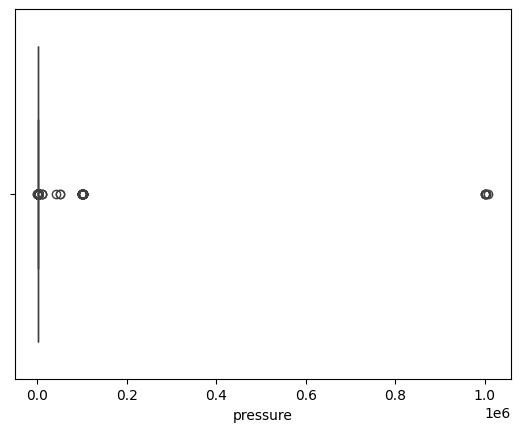

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x=weather_df['pressure'])
plt.show()

El valor de 10MPa es claramente un outlier ya que corresponde a una presión superior a la admisible en la Tierra. Por otro lado, valores inferiores a 931hPa (presión mínima registrada en la península ibérica) serán eliminados también.

In [353]:
# Replace outliers in 'pressure' with NaNs

weather_df['pressure'] = weather_df['pressure'].mask(weather_df['pressure'] > 1051, np.nan)
weather_df['pressure'] = weather_df['pressure'].mask(weather_df['pressure'] < 931, np.nan)


En el caso de la velocidad del viento, se eliminarán los valores superiores a 50m/s

In [354]:
weather_df.loc[weather_df.wind_speed > 50, 'wind_speed'] = np.nan


Finalmente, interpolamos para sustituir los valores nulos.

In [355]:
weather_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


Finalmente, revisamos los valores de 'rain_3h'. Como vemos, los valores de rain_3h no son fiables ya que en la mayoría de los casos son menores que 'rain_1h'. Borramos la columna

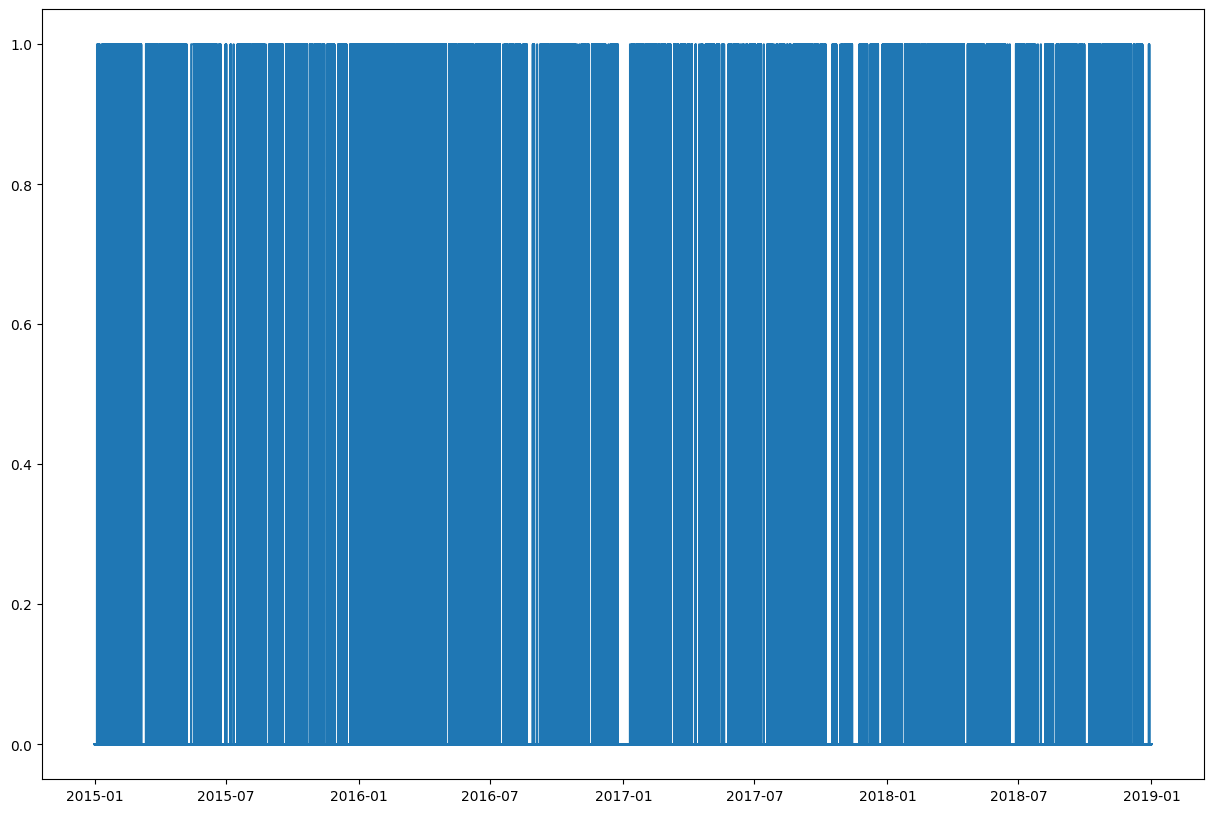

In [356]:
plt.figure(figsize=(15,10))
plt.plot(weather_df['rain_3h']<weather_df['rain_1h'])

In [357]:
weather_df.drop('rain_3h',axis=1,inplace=True)

# Preprocesamiento de datos

In [358]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in weather_df.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [359]:
df_final = energy_df

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price actual', 'year', 'month', 'day_of_week', 'hour',
       'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona',
       'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
       'wind_deg_Barcelona', 'rain_1h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'weather_id_Barcelona', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'snow_3h_Bilbao'

En primer lugar, visualizamos el precio de la electricidad.

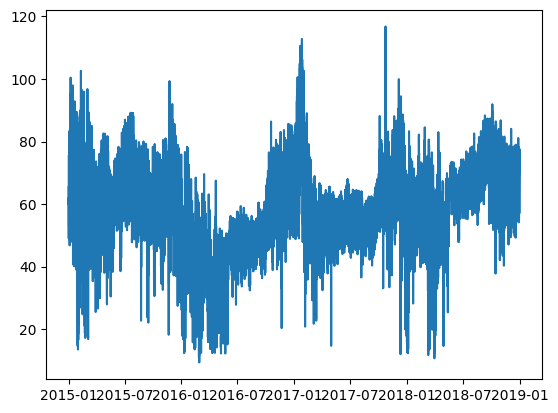

In [360]:
plt.plot(df_final['price actual'])

 Lo primer que podemos ver, es que existe algún tipo de frecuencia. El precio oscila sobre los mismos valores en función de la época del año. Para confirmarlo, visualizamos la comparación del precio entre años.

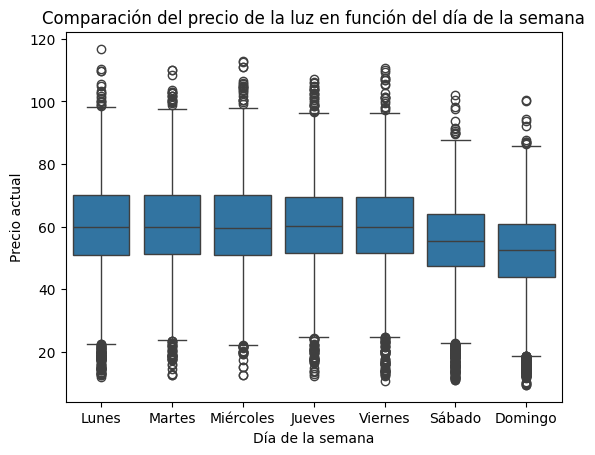

In [361]:
sns.boxplot(x='day_of_week', y='price actual', data=df_final)

# Set the title and labels of the plot
plt.title('Comparación del precio de la luz en función del día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Precio actual')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])

plt.show()

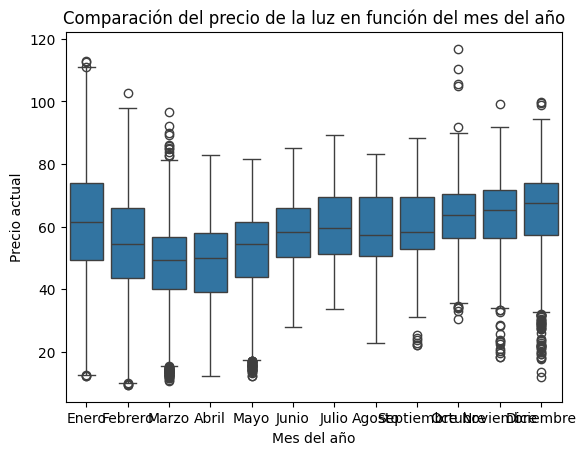

In [362]:
sns.boxplot(x='month', y='price actual', data=df_final)

# Set the title and labels of the plot
plt.title('Comparación del precio de la luz en función del mes del año')
plt.xlabel('Mes del año')
plt.ylabel('Precio actual')
plt.xticks(ticks=range(12), labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                                  'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])
plt.show()

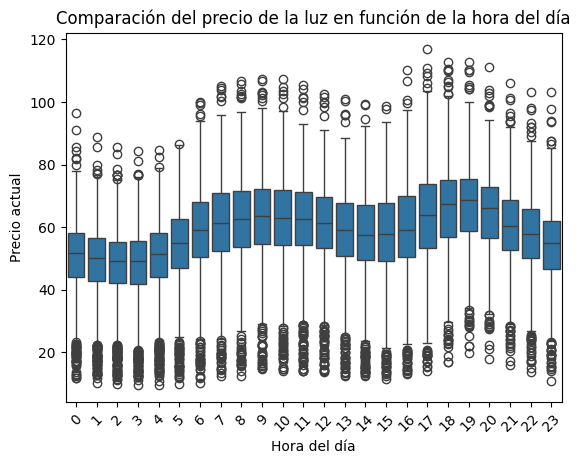

In [363]:
sns.boxplot(x='hour', y='price actual', data=df_final)

# Set the title and labels of the plot
plt.title('Comparación del precio de la luz en función de la hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Precio actual')
plt.xticks(ticks=range(24),rotation=45)

plt.show()

Como podemos ver, el precio final de la luz se ve afectado por la fecha.
- Los días de trabajo (lunes-viernes) el precio es ligeramente superior.
- Los meses de invierno, los precios son ligeramente superiores.
- Durante el día, se observan dos bajadas durante el día: De noche y a la hora de comer.

In [364]:
#Generamos una variable "weekday" para indicar qué día de la semana es. 0-> entre semana, 1-> sábado, 2-> domingo
for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0
#Generamos una variable "business hour" para indicar qué momento del día es. 0->descanso, 1->hora de comer, 2->trabajo

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

# Selección de características
En primer lugar, generamos la correlación entre la variable de precio y el resto de variables. Algunas observaciones:
- Las variables de generación de energía y el total de carga actual están relacionadas positivamente con el precio actual.
- La variable 'generation hydro pumped storage consumption' está negativamente relacionada con el precio actual.
- Eliminamos las variables con correlación nan

In [365]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 77 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [366]:
correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
month                                          0.281219
business hour                                  0.275421
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
hour                                           0.237381
pressure_Bilbao                                0.194063
generation waste                               0.168710
year                                           0.142870
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0

In [367]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

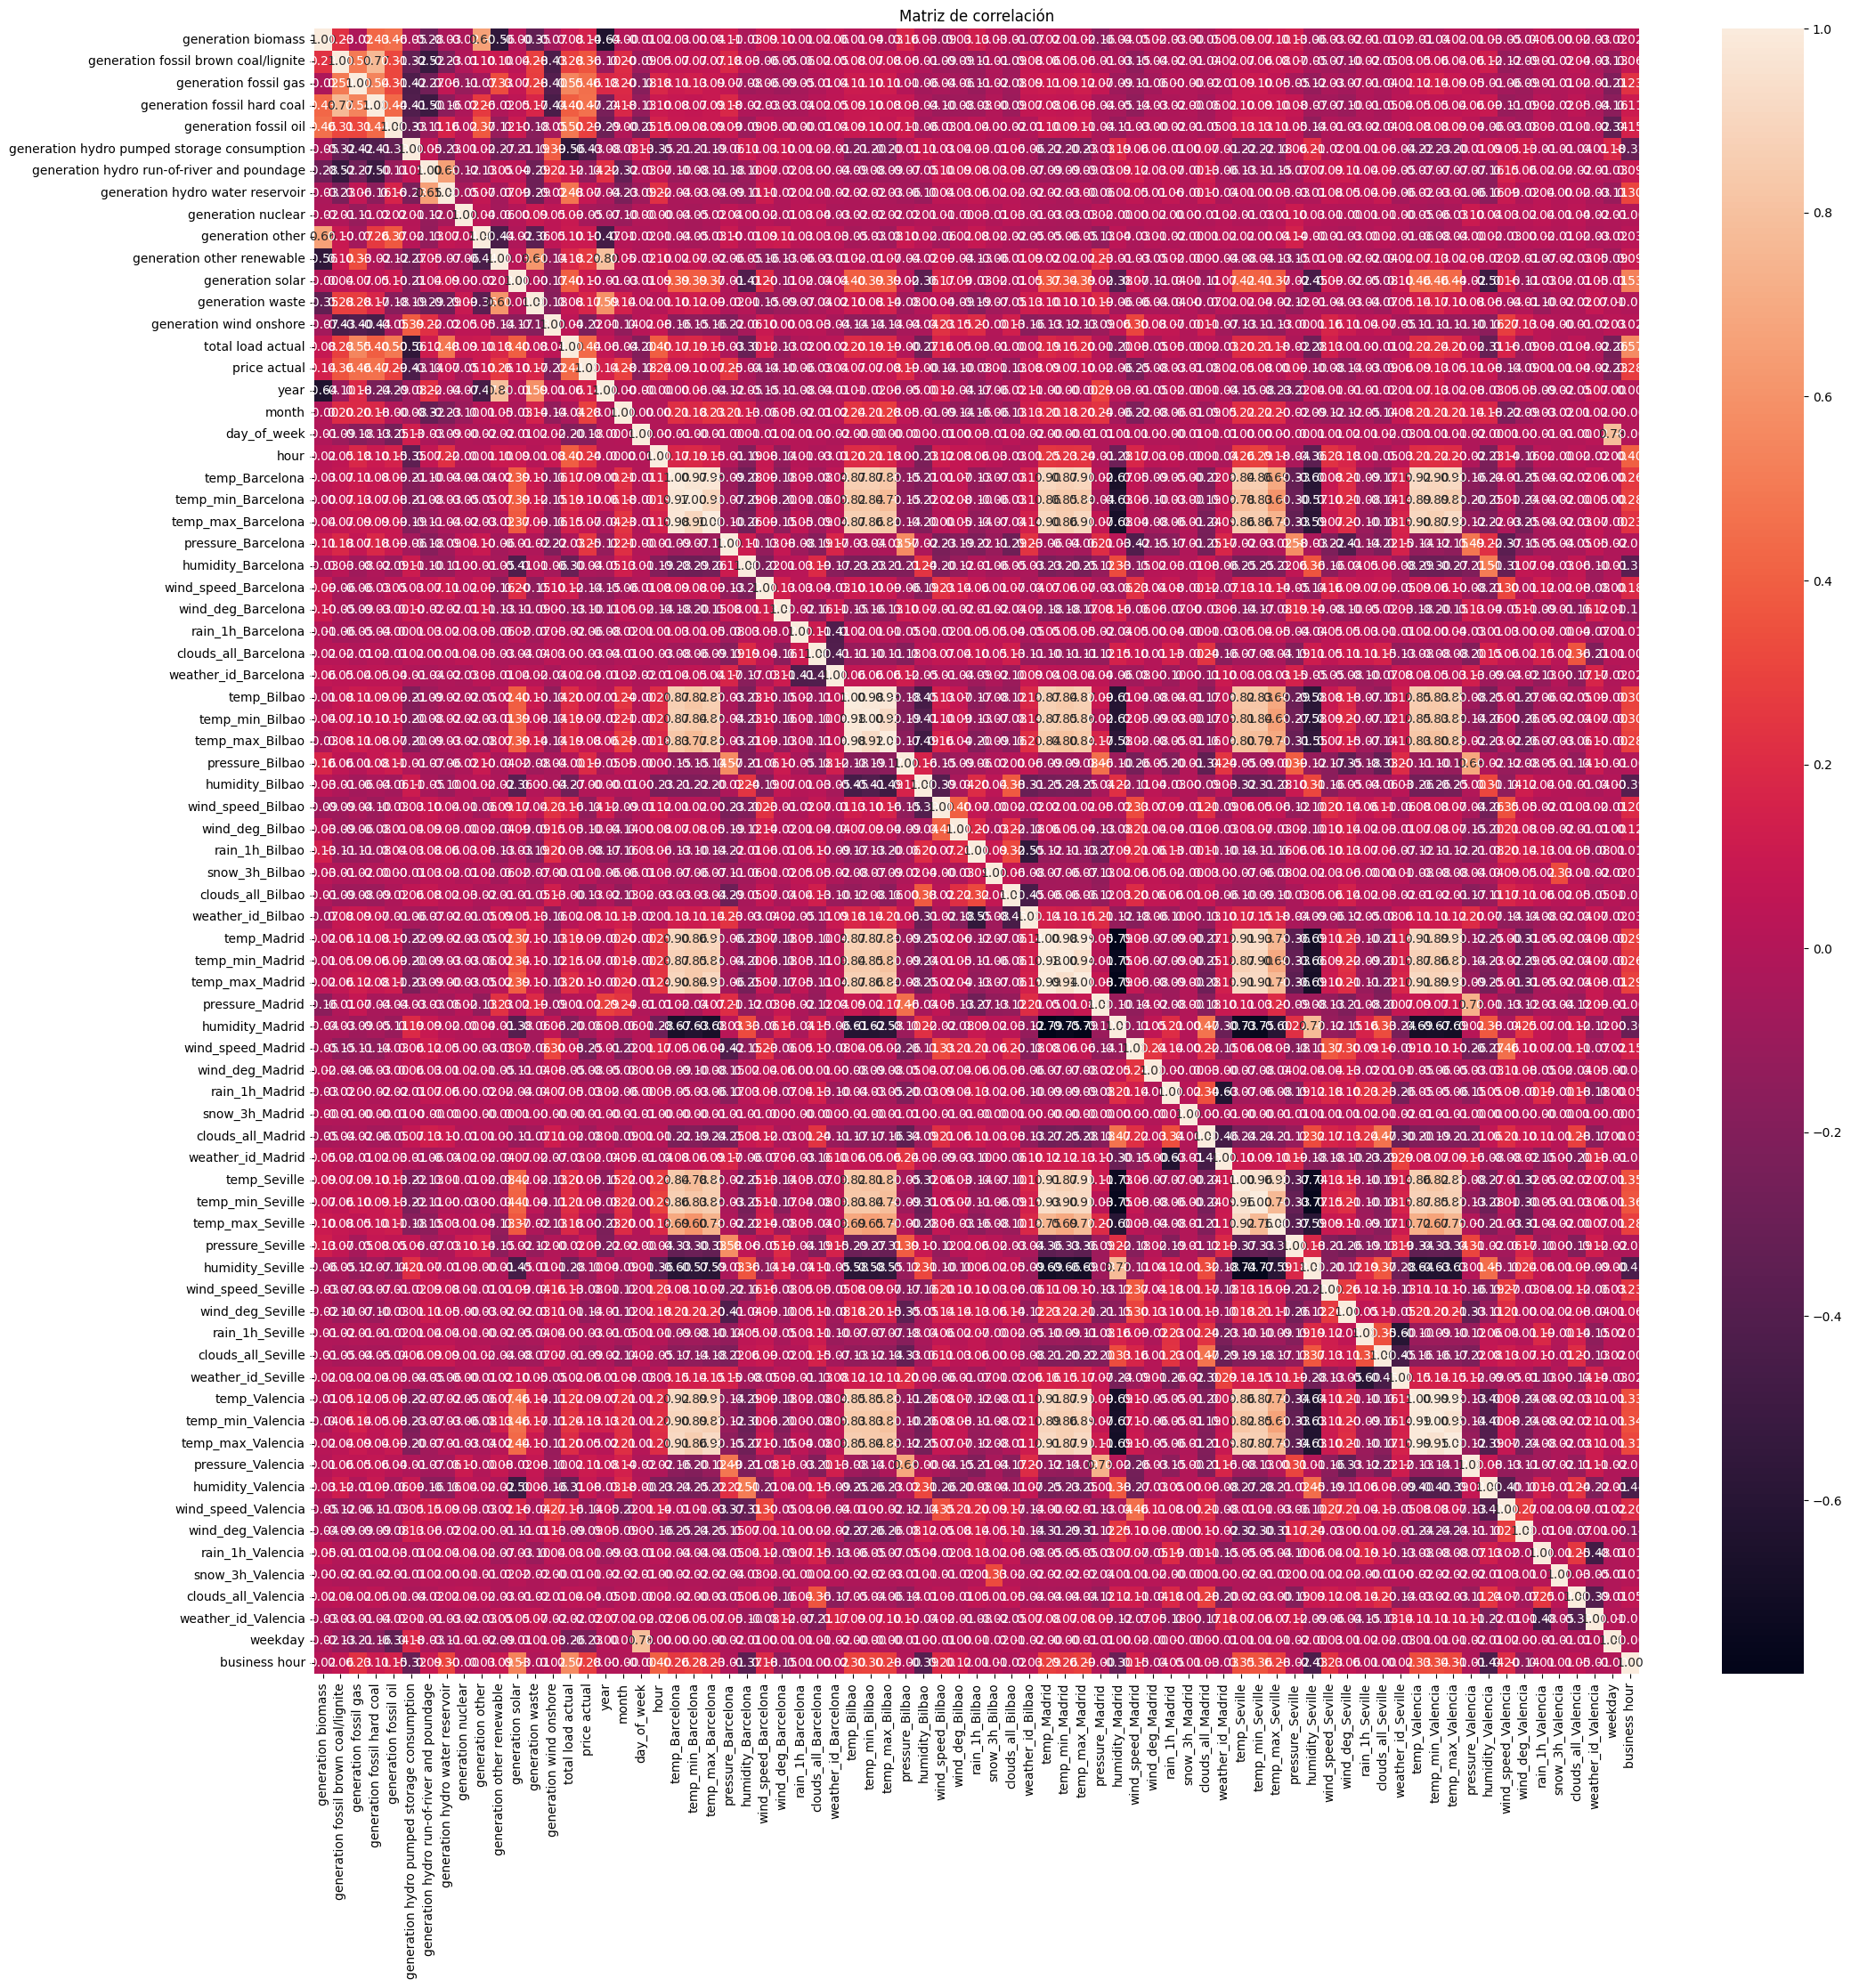

In [368]:
correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

Una de las cosas que podemos ver es que las variables de temperatura están muy relacionadas. Sustituimos las columnas 'temp' 'temp_min' y 'temp_max' por 'temp_range' para simplificar.

In [369]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)
for city in cities:
      df_final.drop(['temp_max_{}'.format(city),'temp_min_{}'.format(city),'temp_{}'.format(city)],axis=1,inplace=True)

Finalmente, eliminamos todas las variables que no usaremos para predecir.

In [370]:
df_final.drop(["day_of_week","hour","year"],inplace=True,axis=1)

# Deep Learning
En primer lugar, separaremos las variables de características (X) de la variable a precedir (Y)

In [371]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [372]:
train_df = df_final.iloc[:train_end_idx,:]
val_df = df_final.iloc[train_end_idx:cv_end_idx,:]
test_df = df_final.iloc[cv_end_idx:test_end_idx,:]
column_indices = {name: i for i, name in enumerate(df_final.columns)}



## Normalización

Es importante escalar las características antes de entrenar una red neuronal. La normalización es una forma común de realizar este escalado: se resta la media y se divide por la desviación estándar de cada característica.

La media y la desviación estándar solo deben calcularse utilizando los datos de entrenamiento para que los modelos no tengan acceso a los valores en los conjuntos de validación y prueba.

También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento mientras se entrena, y que esta normalización debería hacerse utilizando medias móviles. Ese no es el enfoque de este tutorial, y los conjuntos de validación y prueba aseguran que obtengas métricas (algo) honestas. Por lo tanto, en interés de la simplicidad, este tutorial utiliza un promedio simple.

In [373]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<ipython-input-374-a661ecc053aa>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df_final.keys(), rotation=90)


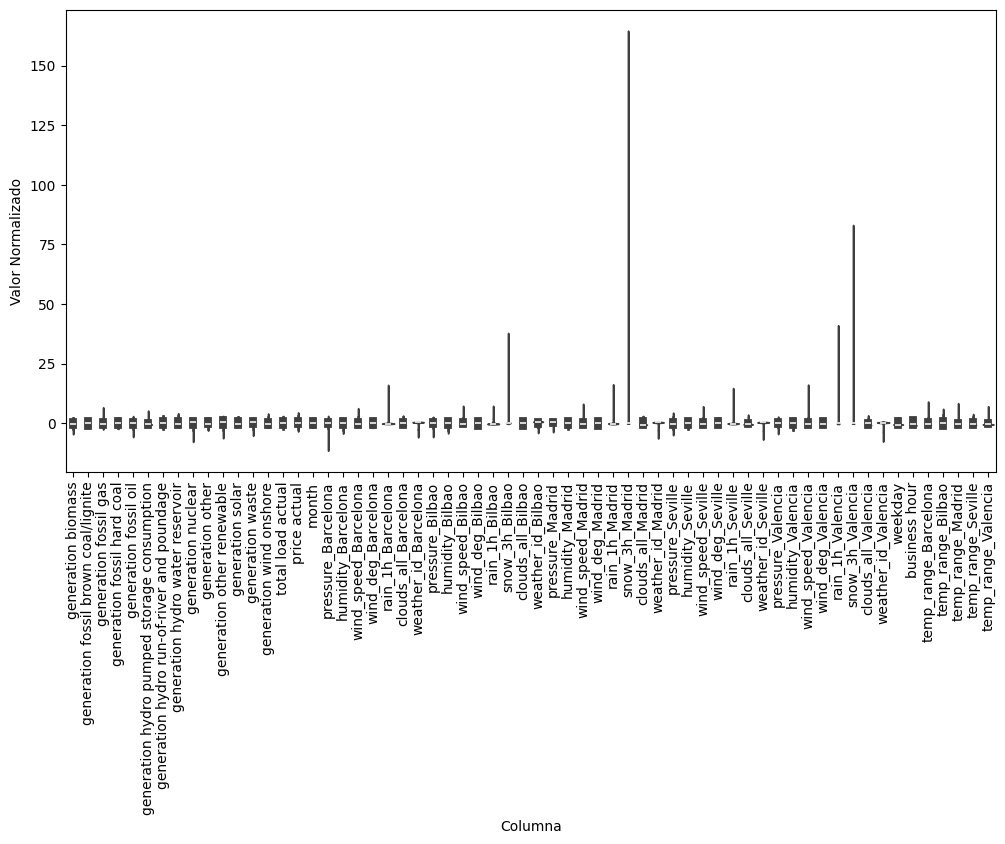

In [374]:
df_std = (df_final - train_mean) / train_std
df_std = df_std.melt(var_name='Columna', value_name='Valor Normalizado')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Valor Normalizado', data=df_std)
_ = ax.set_xticklabels(df_final.keys(), rotation=90)

In [375]:
import tensorflow as tf
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [376]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['price actual'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['price actual']

In [377]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['price actual'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['price actual']

In [378]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [379]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 62)
Inputs shape: (3, 6, 62)
Labels shape: (3, 1, 1)


In [380]:
w2.example = example_inputs, example_labels

In [381]:
def plot(self, model=None, plot_col='price actual', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

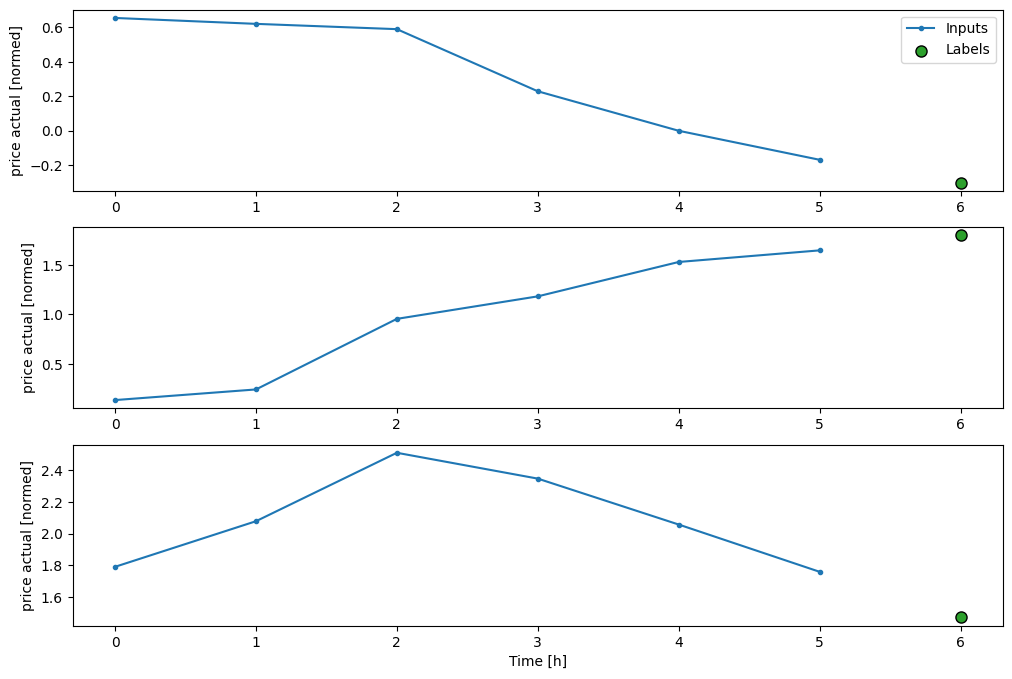

In [382]:
w2.plot()

In [383]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [384]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 62), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [385]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 62)
Labels shape (batch, time, features): (32, 1, 1)


In [386]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['price actual'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price actual']

# Baseline
Antes de construir un modelo entrenable, sería bueno tener una línea base de rendimiento como punto de comparación con los modelos más complicados posteriores.

La primera tarea es predecir la temperatura una hora en el futuro, dada el valor actual de todas las características. Los valores actuales incluyen la temperatura actual.

Por lo tanto, comience con un modelo que simplemente devuelva la temperatura actual como predicción, prediciendo "Sin cambio". Esta es una línea base razonable ya que la temperatura cambia lentamente. Por supuesto, esta línea base funcionará menos bien si haces una predicción más lejana en el futuro.

In [387]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [388]:
#Iniciamos y evaluamos este modelo
baseline = Baseline(label_index=column_indices['price actual'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

126/126 [==============================] - 1s 3ms/step - loss: 0.0539 - mean_absolute_error: 0.1543 - mean_squared_error: 0.0539 - root_mean_squared_error: 0.2322 - mean_absolute_percentage_error: 107.4632


Aunque se muestran algunas métricas, no nos da suficiente información para saber como de bien funciona nuestro modelo.

Generamos un WindowGenerator que genera ventanas más grandes (24 intervalos).

In [389]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['price actual'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['price actual']

In [390]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 62)
Output shape: (32, 24, 1)


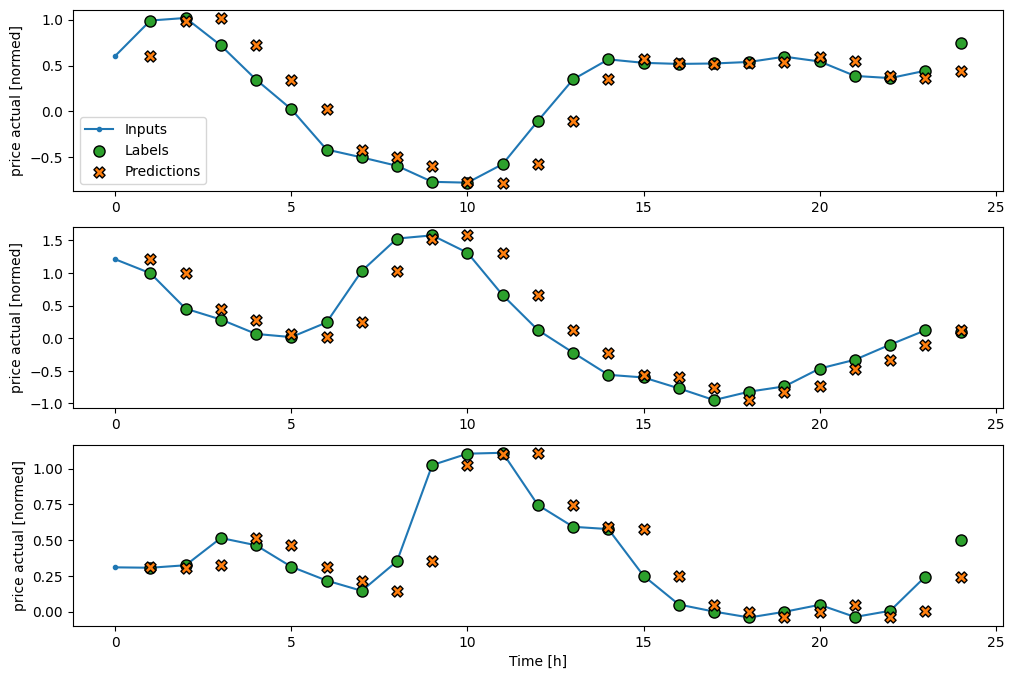

In [391]:
wide_window.plot(baseline)

En los gráficos anteriores de tres ejemplos, el modelo base se ejecuta durante 24 horas.

- La línea azul de Entradas muestra el precio actual en cada etapa de predición. El modelo recibe todas las características, aunque este gráfico solo muestra el precio final.
- Los puntos verdes de Etiquetas muestran el valor de predicción objetivo. Estos puntos se muestran en el momento de la predicción, no en el momento de la entrada. Por eso el rango de las etiquetas se desplaza un paso en relación con las entradas.
- Las cruces naranjas de Predicciones son las predicciones del modelo para cada paso de tiempo de salida. Si el modelo predijera perfectamente, las predicciones caerían directamente sobre las Etiquetas.

# Modelo lineal
El modelo más sencillo que podemos aplicar es es una transformación lineal a la capa de entrada.

In [392]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [393]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 62)
Output shape: (32, 1, 1)


In [394]:
MAX_EPOCHS = 20
#Esta será la función que usaremos para entrenar todos los modelos
def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()]) #Añadimos todas las métricas que queremos calcular

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [395]:
#Entrenamos el modelo y evaluamos
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
846/846 [==============================] - 4s 4ms/step - loss: 0.8060 - mean_absolute_error: 0.6289 - mean_squared_error: 0.8060 - root_mean_squared_error: 0.8978 - mean_absolute_percentage_error: 432.3555 - val_loss: 0.2275 - val_mean_absolute_error: 0.3873 - val_mean_squared_error: 0.2275 - val_root_mean_squared_error: 0.4769 - val_mean_absolute_percentage_error: 207.2554
Epoch 2/20
846/846 [==============================] - 4s 5ms/step - loss: 0.1429 - mean_absolute_error: 0.2802 - mean_squared_error: 0.1429 - root_mean_squared_error: 0.3780 - mean_absolute_percentage_error: 219.6116 - val_loss: 0.0884 - val_mean_absolute_error: 0.2307 - val_mean_squared_error: 0.0884 - val_root_mean_squared_error: 0.2974 - val_mean_absolute_percentage_error: 138.6777
Epoch 3/20
846/846 [==============================] - 3s 3ms/step - loss: 0.0790 - mean_absolute_error: 0.2047 - mean_squared_error: 0.0790 - root_mean_squared_error: 0.2810 - mean_absolute_percentage_error: 171.9901 - val_l

Al igual que el modelo base, el modelo lineal puede aplicarse en lotes de ventanas amplias. Utilizado de esta manera, el modelo realiza un conjunto de predicciones independientes en pasos de tiempo consecutivos. El eje temporal actúa como otro eje de lote. No hay interacciones entre las predicciones en cada paso de tiempo.

In [396]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 62)
Output shape: (32, 24, 1)


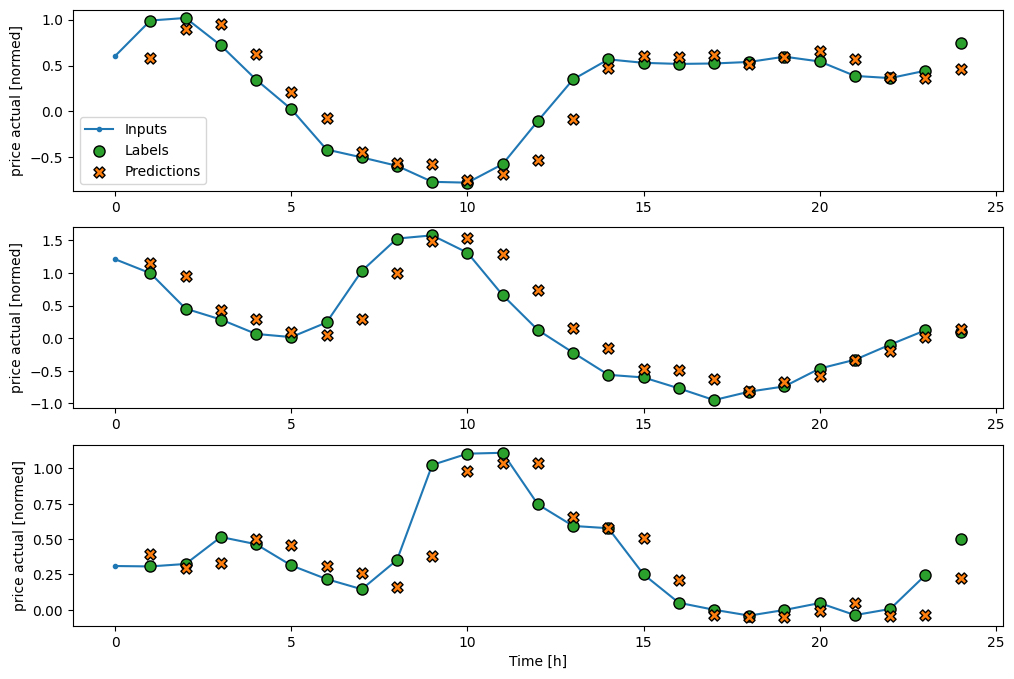

In [397]:
wide_window.plot(linear)

Una ventaja de los modelos lineales es que son relativamente simples de interpretar. Puedes extraer los pesos de la capa y visualizar el peso asignado a cada entrada:

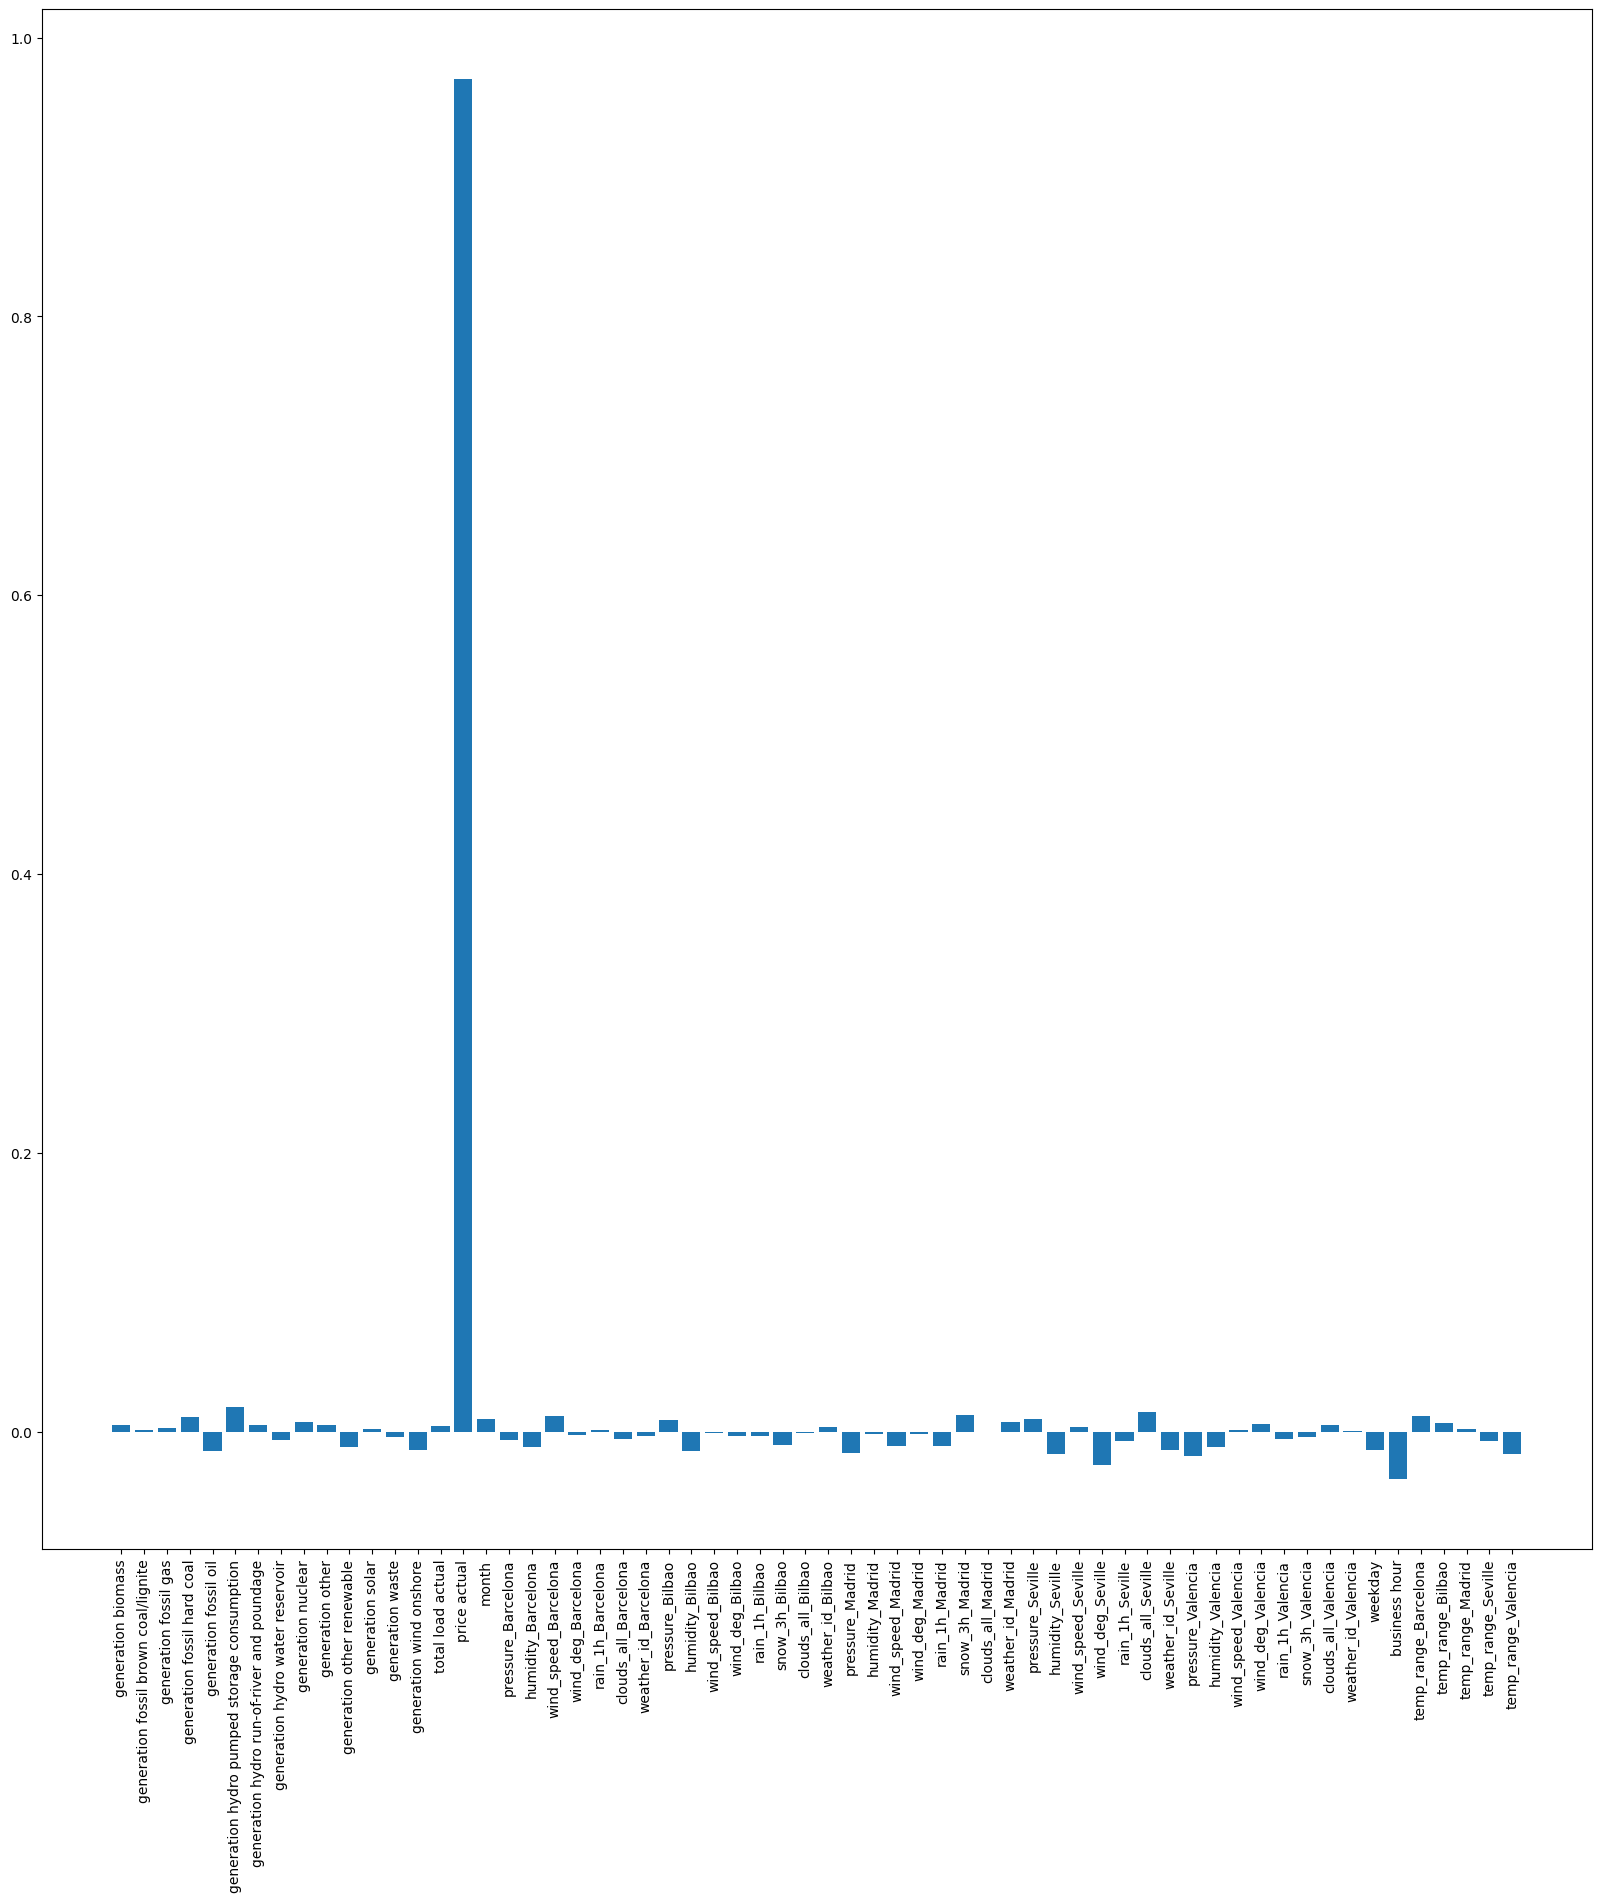

In [398]:
plt.figure(figsize=(20,20))
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


Antes de aplicar modelos que realmente operan en múltiples pasos de tiempo, vale la pena verificar el rendimiento de modelos de un solo paso de entrada más profundos y potentes.

Aquí hay un modelo similar al modelo lineal, excepto que apila varias capas Densas entre la entrada y la salida:

In [399]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
846/846 [==============================] - 5s 5ms/step - loss: 0.1831 - mean_absolute_error: 0.2900 - mean_squared_error: 0.1831 - root_mean_squared_error: 0.4279 - mean_absolute_percentage_error: 235.8628 - val_loss: 0.0966 - val_mean_absolute_error: 0.2362 - val_mean_squared_error: 0.0966 - val_root_mean_squared_error: 0.3109 - val_mean_absolute_percentage_error: 143.2559
Epoch 2/20
846/846 [==============================] - 5s 6ms/step - loss: 0.0851 - mean_absolute_error: 0.2078 - mean_squared_error: 0.0851 - root_mean_squared_error: 0.2917 - mean_absolute_percentage_error: 192.4821 - val_loss: 0.0804 - val_mean_absolute_error: 0.2113 - val_mean_squared_error: 0.0804 - val_root_mean_squared_error: 0.2836 - val_mean_absolute_percentage_error: 142.8925
Epoch 3/20
846/846 [==============================] - 3s 4ms/step - loss: 0.0984 - mean_absolute_error: 0.1967 - mean_squared_error: 0.0984 - root_mean_squared_error: 0.3136 - mean_absolute_percentage_error: 172.5300 - val_l

El principal problema a la hora de utilizar estos modelos, es que no se añade información del contexto en intervalos anteriores. Por este motivo vamos a probar a añadir varios intervalos en la capa de entrada.

Los modelos base, lineal y denso trataron cada paso de tiempo de manera independiente. Aquí, el modelo tomará múltiples pasos de tiempo como entrada para producir una única salida.

Crea un WindowGenerator que producirá lotes de entradas de tres horas y etiquetas de una hora:

Ten en cuenta que el parámetro de desplazamiento de la Ventana es relativo al final de las dos ventanas.

In [400]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['price actual'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['price actual']

Text(0.5, 0.98, 'Dada la información de las últimas 3h, predice 1 h a futuro')

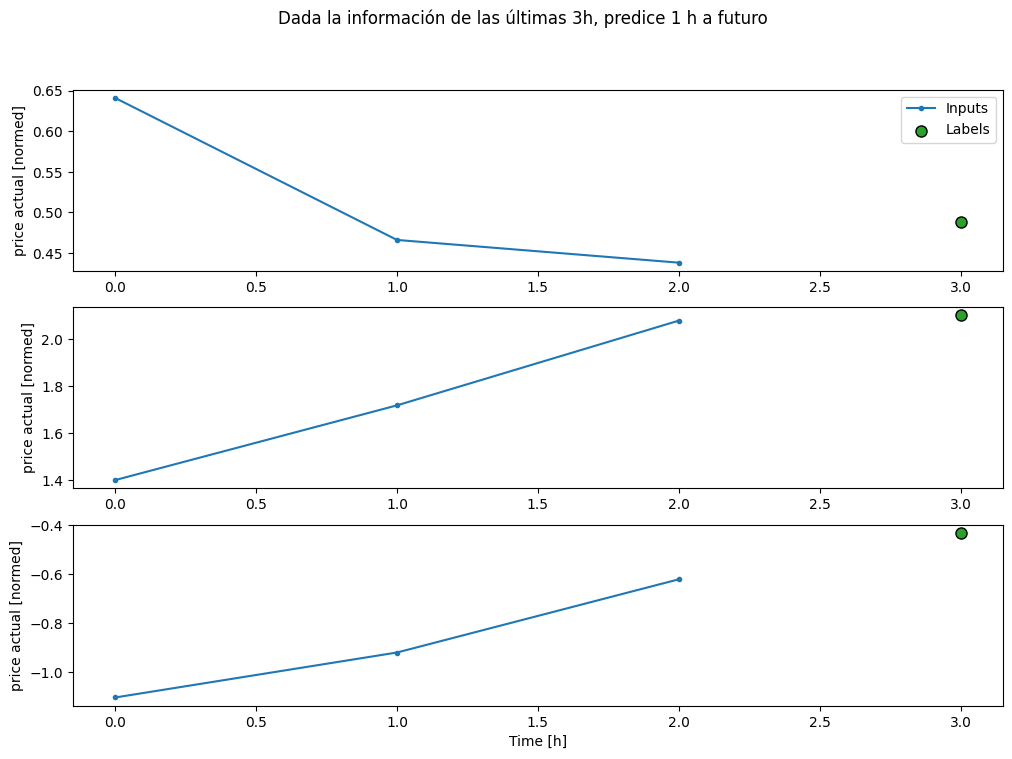

In [401]:
conv_window.plot()
plt.suptitle("Dada la información de las últimas 3h, predice 1 h a futuro")

In [402]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [403]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 62)
Output shape: (32, 1, 1)


In [404]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

Epoch 1/20
846/846 [==============================] - 5s 4ms/step - loss: 0.2015 - mean_absolute_error: 0.3229 - mean_squared_error: 0.2015 - root_mean_squared_error: 0.4489 - mean_absolute_percentage_error: 239.3437 - val_loss: 0.1163 - val_mean_absolute_error: 0.2698 - val_mean_squared_error: 0.1163 - val_root_mean_squared_error: 0.3411 - val_mean_absolute_percentage_error: 170.1653
Epoch 2/20
846/846 [==============================] - 3s 4ms/step - loss: 0.0781 - mean_absolute_error: 0.2085 - mean_squared_error: 0.0781 - root_mean_squared_error: 0.2794 - mean_absolute_percentage_error: 174.3413 - val_loss: 0.1134 - val_mean_absolute_error: 0.2652 - val_mean_squared_error: 0.1134 - val_root_mean_squared_error: 0.3367 - val_mean_absolute_percentage_error: 172.1628
Epoch 3/20
846/846 [==============================] - 5s 6ms/step - loss: 0.0622 - mean_absolute_error: 0.1830 - mean_squared_error: 0.0622 - root_mean_squared_error: 0.2495 - mean_absolute_percentage_error: 156.8633 - val_l

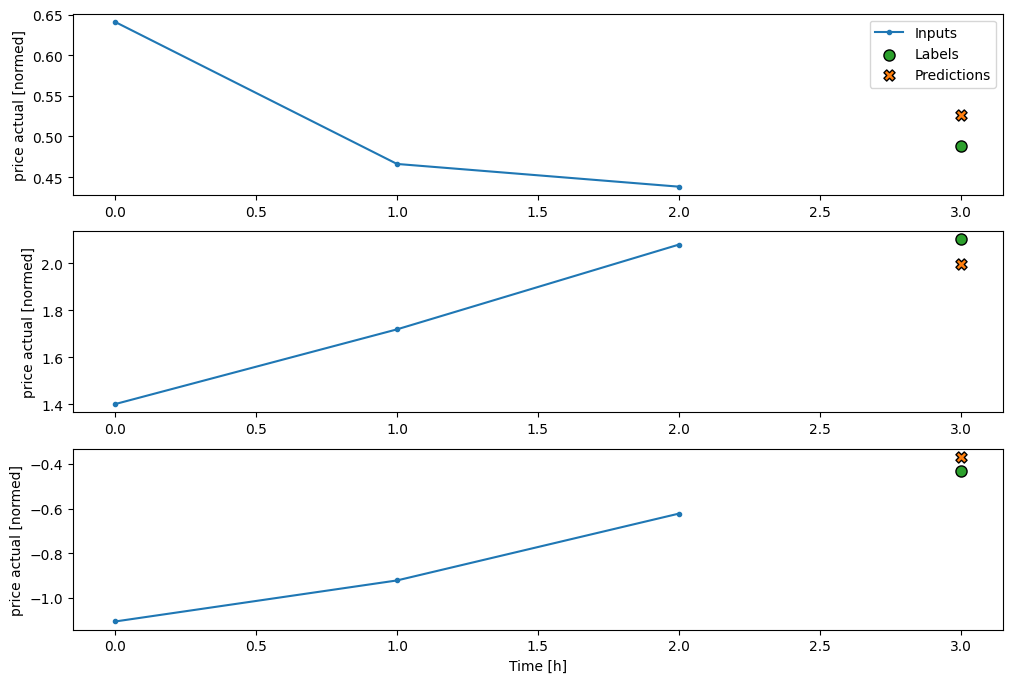

In [405]:
conv_window.plot(multi_step_dense)

# Redes convolucionales


In [406]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [407]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 62)
Output shape: (32, 1, 1)


In [408]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

Epoch 1/20
846/846 [==============================] - 5s 4ms/step - loss: 0.1763 - mean_absolute_error: 0.3001 - mean_squared_error: 0.1763 - root_mean_squared_error: 0.4199 - mean_absolute_percentage_error: 211.1838 - val_loss: 0.0992 - val_mean_absolute_error: 0.2497 - val_mean_squared_error: 0.0992 - val_root_mean_squared_error: 0.3150 - val_mean_absolute_percentage_error: 145.5154
Epoch 2/20
846/846 [==============================] - 4s 5ms/step - loss: 0.0706 - mean_absolute_error: 0.1974 - mean_squared_error: 0.0706 - root_mean_squared_error: 0.2656 - mean_absolute_percentage_error: 163.0327 - val_loss: 0.0693 - val_mean_absolute_error: 0.2042 - val_mean_squared_error: 0.0693 - val_root_mean_squared_error: 0.2632 - val_mean_absolute_percentage_error: 138.2757
Epoch 3/20
846/846 [==============================] - 3s 4ms/step - loss: 0.0544 - mean_absolute_error: 0.1738 - mean_squared_error: 0.0544 - root_mean_squared_error: 0.2333 - mean_absolute_percentage_error: 153.7338 - val_l

La diferencia entre este modelo convolucional (conv_model) y el modelo denso de múltiples pasos (multi_step_dense) es que el conv_model se puede ejecutar en entradas de cualquier longitud. La capa convolucional se aplica a una ventana deslizante de entradas:

In [409]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 62)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Ten en cuenta que la salida es más corta que la entrada. Para que el entrenamiento o la creación de gráficos funcione, necesitas que las etiquetas y las predicciones tengan la misma longitud. Por lo tanto, construye un WindowGenerator para producir ventanas amplias con algunos pasos de tiempo de entrada adicionales para que las longitudes de las etiquetas y las predicciones coincidan:

In [410]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['price actual'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['price actual']

In [411]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 62)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


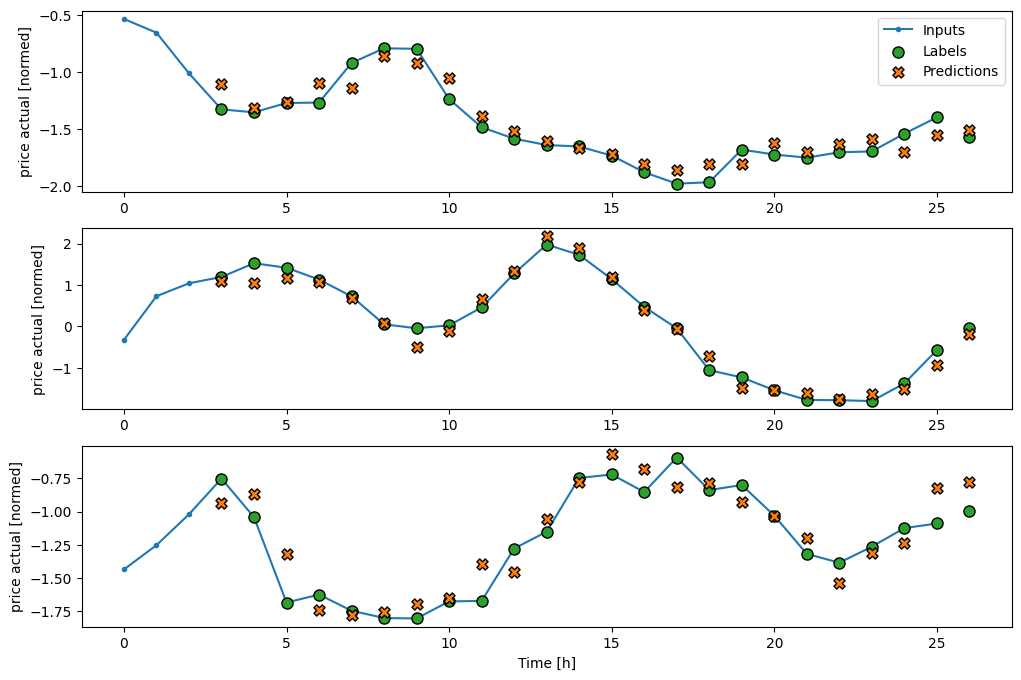

In [412]:
wide_conv_window.plot(conv_model)

# Redes Neurales Recurrentes (RNN)

In [413]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [414]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 62)
Output shape: (32, 24, 1)


In [415]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/20
845/845 [==============================] - 18s 18ms/step - loss: 0.1506 - mean_absolute_error: 0.2708 - mean_squared_error: 0.1506 - root_mean_squared_error: 0.3881 - mean_absolute_percentage_error: 200.7463 - val_loss: 0.0610 - val_mean_absolute_error: 0.1867 - val_mean_squared_error: 0.0610 - val_root_mean_squared_error: 0.2470 - val_mean_absolute_percentage_error: 150.6807
Epoch 2/20
845/845 [==============================] - 15s 18ms/step - loss: 0.0384 - mean_absolute_error: 0.1434 - mean_squared_error: 0.0384 - root_mean_squared_error: 0.1959 - mean_absolute_percentage_error: 119.6541 - val_loss: 0.0434 - val_mean_absolute_error: 0.1539 - val_mean_squared_error: 0.0434 - val_root_mean_squared_error: 0.2082 - val_mean_absolute_percentage_error: 139.4733
Epoch 3/20
845/845 [==============================] - 14s 17ms/step - loss: 0.0305 - mean_absolute_error: 0.1268 - mean_squared_error: 0.0305 - root_mean_squared_error: 0.1748 - mean_absolute_percentage_error: 106.9240 -

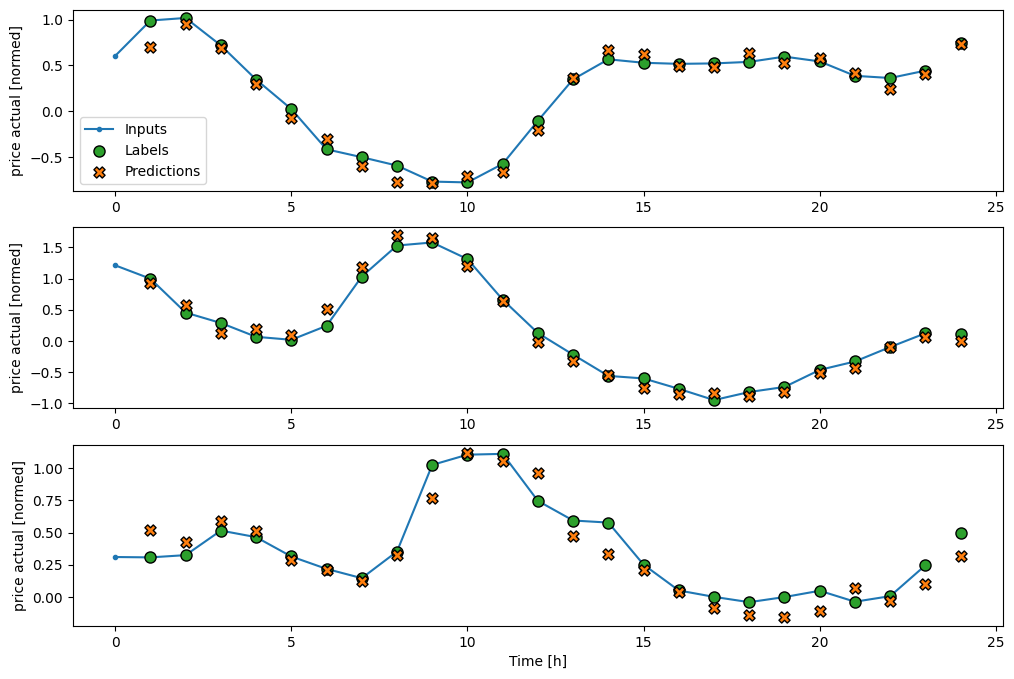

In [416]:
wide_window.plot(lstm_model)

## GRU

In [417]:
gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [418]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', gru_model(wide_window.example[0]).shape)

Input shape: (32, 24, 62)
Output shape: (32, 24, 1)


In [419]:
history = compile_and_fit(gru_model, wide_window)

val_performance['GRU'] = gru_model.evaluate(wide_window.val, return_dict=True)
performance['GRU'] = gru_model.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/20
845/845 [==============================] - 18s 18ms/step - loss: 0.1372 - mean_absolute_error: 0.2494 - mean_squared_error: 0.1372 - root_mean_squared_error: 0.3705 - mean_absolute_percentage_error: 180.0355 - val_loss: 0.0499 - val_mean_absolute_error: 0.1653 - val_mean_squared_error: 0.0499 - val_root_mean_squared_error: 0.2235 - val_mean_absolute_percentage_error: 141.3044
Epoch 2/20
845/845 [==============================] - 14s 17ms/step - loss: 0.0376 - mean_absolute_error: 0.1408 - mean_squared_error: 0.0376 - root_mean_squared_error: 0.1939 - mean_absolute_percentage_error: 119.3273 - val_loss: 0.0415 - val_mean_absolute_error: 0.1495 - val_mean_squared_error: 0.0415 - val_root_mean_squared_error: 0.2037 - val_mean_absolute_percentage_error: 136.7700
Epoch 3/20
845/845 [==============================] - 15s 17ms/step - loss: 0.0313 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0313 - root_mean_squared_error: 0.1769 - mean_absolute_percentage_error: 112.4724 -

# Resultados

In [420]:
val_performance

{'Baseline': {'loss': 0.05393701419234276,
  'mean_absolute_error': 0.15434400737285614,
  'mean_squared_error': 0.05393701419234276,
  'root_mean_squared_error': 0.23224343359470367,
  'mean_absolute_percentage_error': 107.46318817138672},
 'Linear': {'loss': 0.05462702363729477,
  'mean_absolute_error': 0.1593681126832962,
  'mean_squared_error': 0.05462702363729477,
  'root_mean_squared_error': 0.23372425138950348,
  'mean_absolute_percentage_error': 110.48792266845703},
 'Dense': {'loss': 0.06666654348373413,
  'mean_absolute_error': 0.1931096613407135,
  'mean_squared_error': 0.06666654348373413,
  'root_mean_squared_error': 0.25819864869117737,
  'mean_absolute_percentage_error': 129.0300750732422},
 'Multi step dense': {'loss': 0.05206720530986786,
  'mean_absolute_error': 0.17038513720035553,
  'mean_squared_error': 0.05206720530986786,
  'root_mean_squared_error': 0.22818239033222198,
  'mean_absolute_percentage_error': 121.70425415039062},
 'Conv': {'loss': 0.0535879097878932

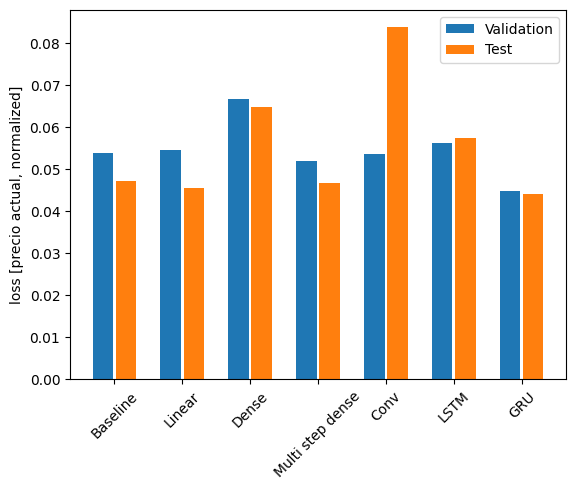

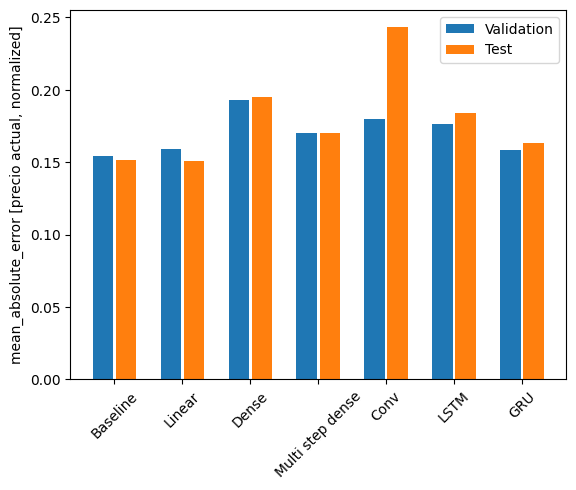

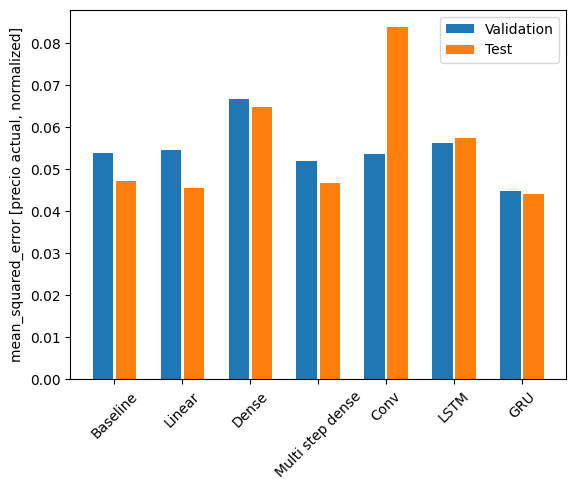

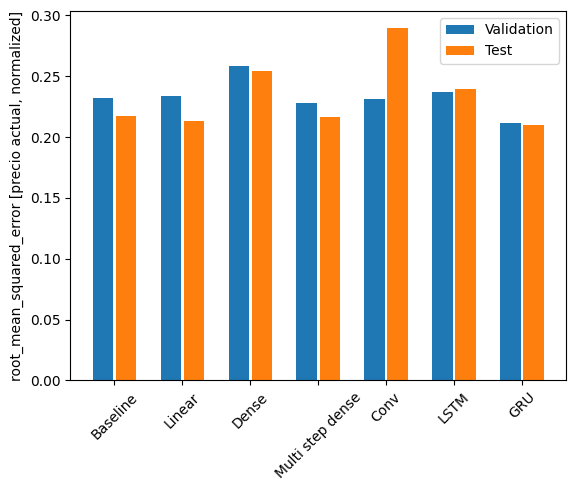

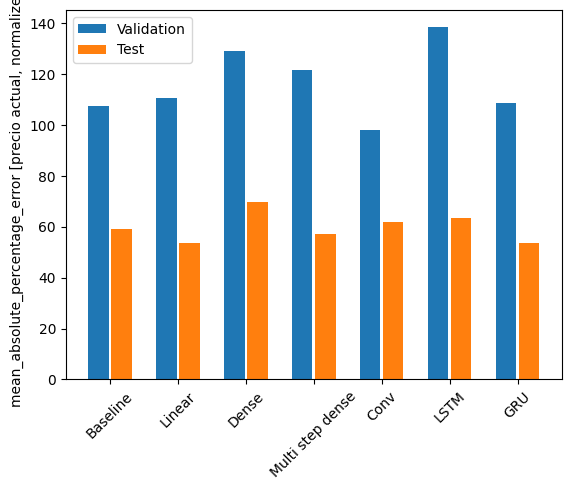

In [424]:
x = np.arange(len(performance))
width = 0.3

for metric_name in val_performance['Linear'].keys():
  plt.figure()
  val_mae = [v[metric_name] for v in val_performance.values()]
  test_mae = [v[metric_name] for v in performance.values()]

  plt.ylabel(f'{metric_name} [precio actual, normalized]')
  plt.bar(x - 0.17, val_mae, width, label='Validation')
  plt.bar(x + 0.17, test_mae, width, label='Test')
  plt.xticks(ticks=x, labels=performance.keys(),
            rotation=45)
  _ = plt.legend()
  plt.show()

In [422]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 59.0016
Linear      : 53.7520
Dense       : 69.8354
Multi step dense: 57.2328
Conv        : 61.7757
LSTM        : 63.2513
GRU         : 53.7545
